# Центральная предельная теорема

Центральные предельные теоремы (ЦПТ) — класс теорем в теории вероятностей, утверждающих, 
что сумма достаточно большого количества слабо зависимых случайных величин, имеющих примерно 
одинаковые масштабы (ни одно из слагаемых не доминирует, не вносит в сумму определяющего вклада), 
имеет распределение, близкое к нормальному.

In [19]:
from statistics import multimode

import numpy as np
import scipy.stats as sps
import ipywidgets as widgets
import matplotlib.pyplot as plt
import PyPDF2
import re

from collections import Counter
from collections import OrderedDict

%matplotlib inline

In [44]:
def extract_from_pdf(variant):
    
    reader = PyPDF2.PdfReader('datasets/Непрерывные величны, практикум 1.pdf')
    message = 'Вариант '
    variant = f'Вариант {N}'
    
    for i in range(len(reader.pages)):
    
        text = reader.pages[i].extract_text()
    
        if variant in text:
            
            index = text.index(str(N))
            end = index
            
            while not end == len(text) and not text[end] == 'В':
                message += text[end]
                end += 1
                
            return message

In [45]:
def load_parameters(message):
    
    parameters = re.findall(r'\w+', message)
    
    μ = int(parameters[-2])
    σ_square = int(parameters[-1])
    
    return (μ, np.sqrt(σ_square))

In [57]:
def transform_to_distribution(μ, σ_square, size = 100, bin_count = 15):
    
    normal = sps.norm.rvs(size = size, loc = μ, scale = σ_square)

    bins = np.linspace(min(normal), max(normal), num = bin_count)
            
    counter = Counter(np.digitize(normal, bins))
    oredered = OrderedDict(sorted(counter.items(), key = lambda t: t[0]))

    data = dict.fromkeys(bins, 0)

    for key, count in oredered.items():
        data[bins[key - 1]] = count
        
    return (normal, data)

Вариант 14
X распределен по закону N(2, 5)



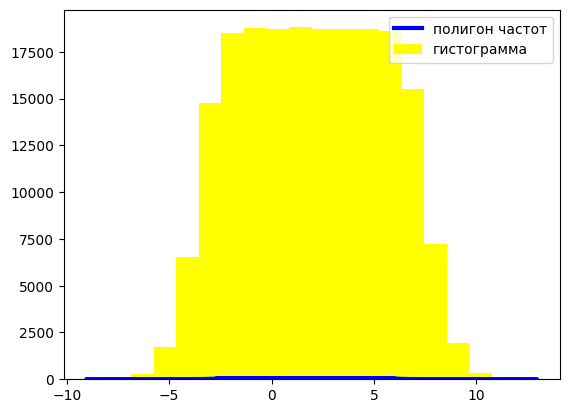

In [79]:
N = 14
bin_count = 20
size = 100

message = extract_from_pdf(N)
print(message)

μ, σ = load_parameters(message)

summary = {}
distribution = [0] * size

for i in range(100, 1000):
    
    normal, data = transform_to_distribution(μ, σ, size = size, bin_count = bin_count)

    distribution += normal
    
    for key, value in data.items():
        summary[key] = data.get(key, 0) + value
    

plt.figure()
plt.plot(summary.keys(), summary.values(), color = 'blue', lw = 3, label = 'полигон частот')
plt.hist(summary, bin_count, color = 'yellow', label = 'гистограмма')
plt.legend()
plt.show()